In [1]:
import pandas as pd # import necessary libraries
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl
import re
from gensim import corpora
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import warnings
warnings.filterwarnings("ignore")

import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

%matplotlib inline

In [ ]:
#Then we test 8 different combinations to see which combination is the best

# Text + All 3 Numerical Features

In [2]:
feature_df = pd.read_csv('./cleaned_csv/feature_df.csv',low_memory=False)
print('rows:',len(feature_df))

rows: 239850


In [3]:
feature_df.dropna(inplace = True)

In [4]:
feature_df = feature_df.sample(n=5000)

In [5]:
feature_df.sentiment.value_counts()

Poor       1685
Neutral    1661
Good       1654
Name: sentiment, dtype: int64

In [6]:
feature_df.head(1)

,sentiment,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
16924,Neutral,grab fry way,0.037037,0.0681,0.333333


In [7]:
y = feature_df["sentiment"]

In [8]:
y

16924     Neutral
211921       Poor
15007     Neutral
173774       Poor
144408       Good
           ...   
121857       Good
37235     Neutral
161024       Poor
225052       Poor
37316     Neutral
Name: sentiment, Length: 5000, dtype: object

In [9]:
x = feature_df.drop(columns = ["sentiment"])

In [10]:
x.head(1)

,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
16924,grab fry way,0.037037,0.0681,0.333333


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, feature_df["sentiment"], test_size=0.2, random_state=123)

In [12]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (4000, 4)
y_train shape: (4000,)

x_test shape: (1000, 4)
y_test shape: (1000,)



In [13]:
#Count Vectors as features

In [14]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(feature_df['cleaned_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train["cleaned_text"])
xvalid_count =  count_vect.transform(x_test["cleaned_text"])

In [15]:
#create df for the vectors (both train and test)

In [16]:
x_train_count_vect_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names(),index= x_train.index)

In [17]:
x_test_count_vect_df = pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names(),index= x_test.index)

In [18]:
#concat x train data (merge with previously created features)
x_train_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_count = pd.concat([x_train_ready_for_concat, x_train_count_vect_df], axis=1)

In [19]:
#concat x test data (merge with previously created features)
x_test_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_count = pd.concat([x_test_ready_for_concat, x_test_count_vect_df], axis=1)

In [20]:
#def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

    
dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_count, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_count, y_train)
    y_pred = clf.predict(xvalid_count)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.9136    0.8488    0.8800       324
     Neutral     0.7728    0.9099    0.8358       344
        Good     0.8435    0.7470    0.7923       332

    accuracy                         0.8360      1000
   macro avg     0.8433    0.8352    0.8360      1000
weighted avg     0.8419    0.8360    0.8357      1000

RF
              precision    recall  f1-score   support

        Poor     0.9359    0.8117    0.8694       324
     Neutral     0.7700    0.8953    0.8280       344
        Good     0.8088    0.7771    0.7926       332

    accuracy                         0.8290      1000
   macro avg     0.8382    0.8281    0.8300      1000
weighted avg     0.8366    0.8290    0.8297      1000

SVM
              precision    recall  f1-score   support

        Poor     0.9598    0.7377    0.8342       324
     Neutral     0.7827    0.8692    0.8237       344
        Good     0.7344    0.8163    0.7732       332

    ac

In [21]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,3.368988,0.126489,0.82625,0.826441,LogReg
1,3.716146,0.123208,0.83875,0.839683,LogReg
2,3.203365,0.141957,0.83000,0.829816,LogReg
3,3.565145,0.128934,0.82875,0.828435,LogReg
4,3.472014,0.132718,0.82250,0.822672,LogReg
5,10.062288,0.234437,0.80625,0.806568,RF
6,10.657050,0.197422,0.80750,0.808025,RF
7,10.315265,0.162649,0.82000,0.818952,RF
8,10.402198,0.182276,0.81625,0.816730,RF
9,10.135189,0.189672,0.81375,0.814953,RF


In [22]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

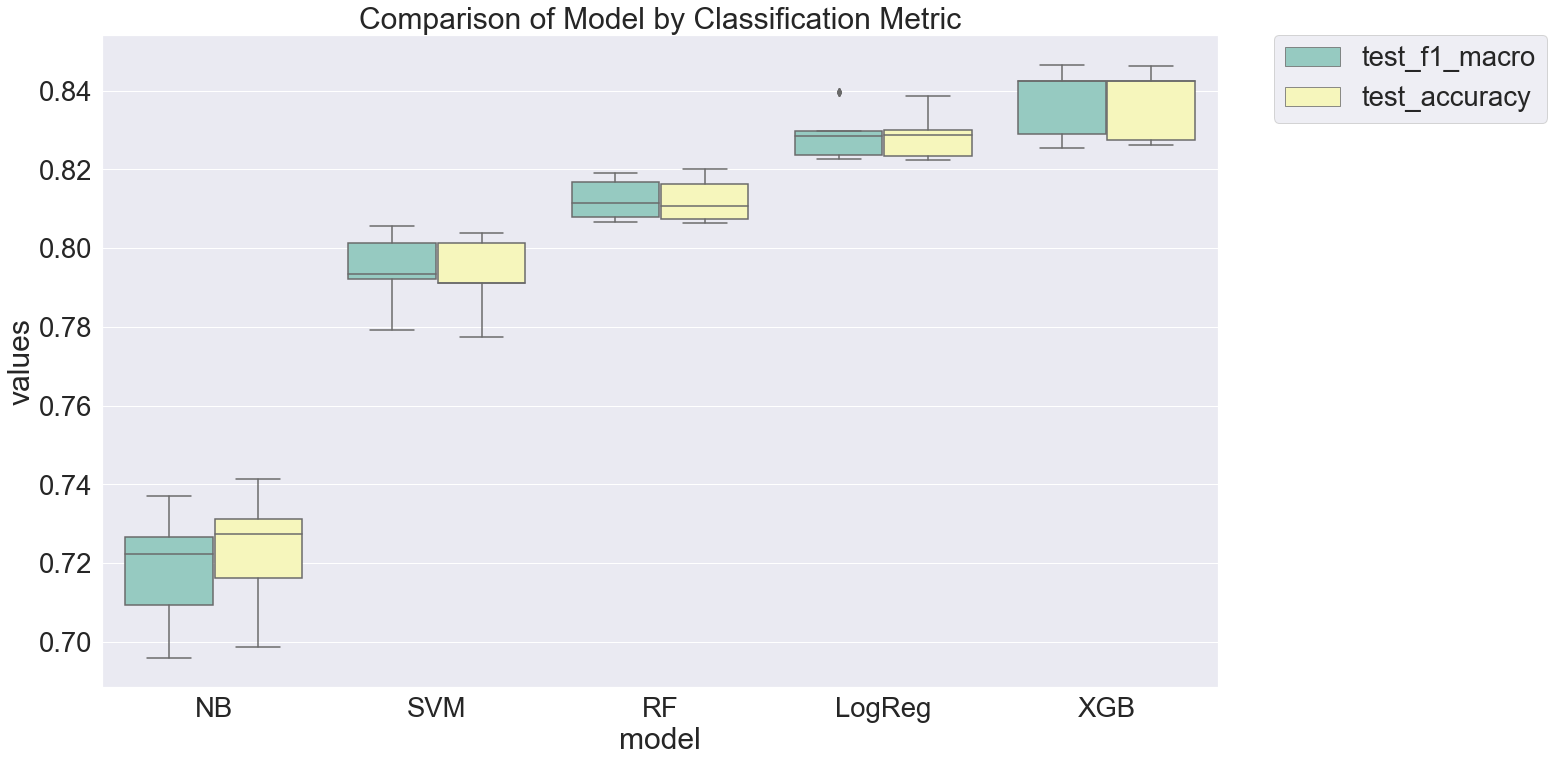

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

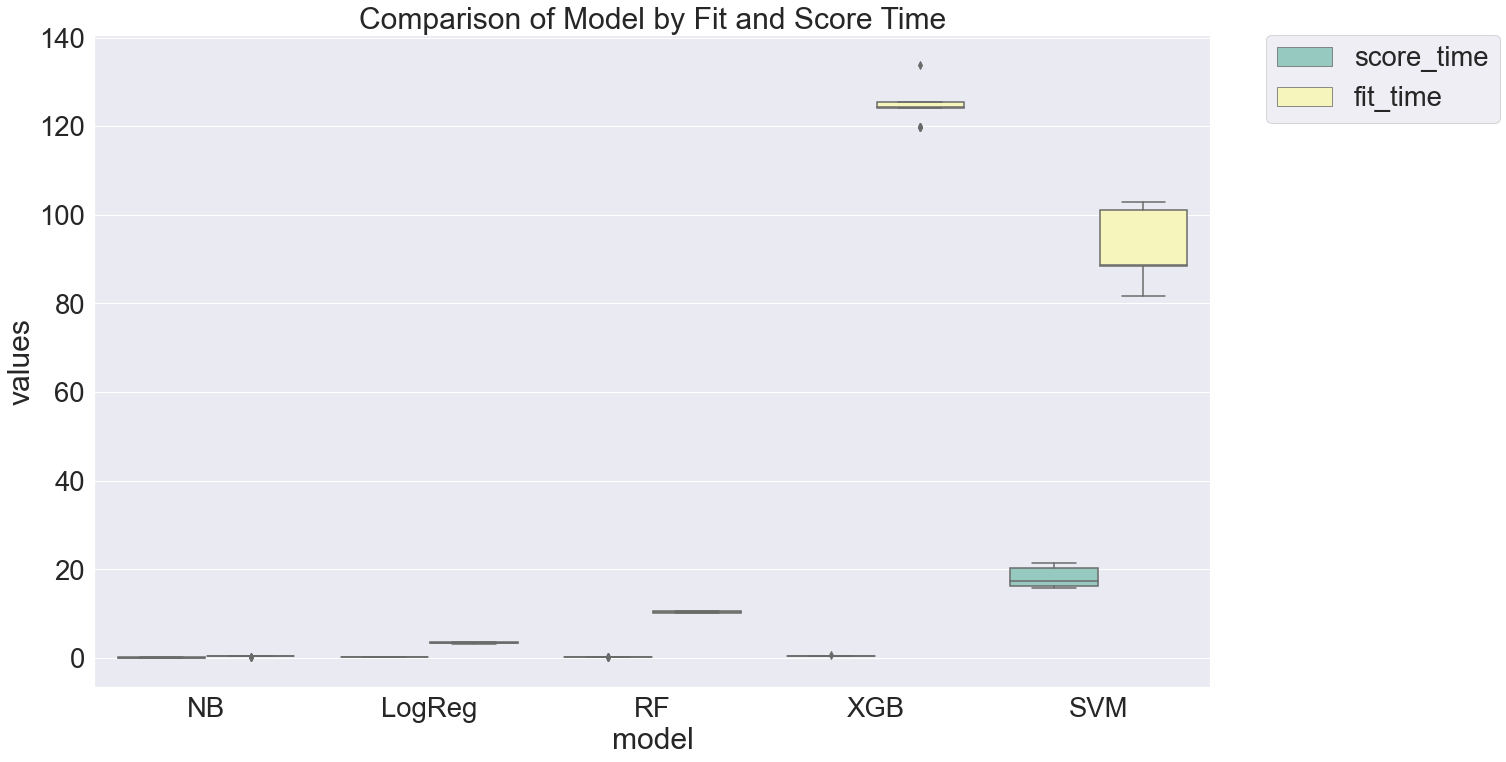

In [24]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [25]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.829333  0.005979      0.829533  0.006277
NB          0.723917  0.013272      0.719166  0.012936
RF          0.812167  0.005609      0.812368  0.005179
SVM         0.793292  0.008799      0.794552  0.008482
XGB         0.836417  0.008659      0.836501  0.008669

In [26]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

score_time              fit_time          
             mean       std        mean       std
model                                            
LogReg   0.130885  0.006621    3.477033  0.179588
NB       0.098566  0.017799    0.371685  0.033595
RF       0.193659  0.024507   10.354786  0.231071
SVM     17.870026  2.215124   92.028351  8.065416
XGB      0.481693  0.032751  124.074287  2.814847

# Text + "Original Word Count"

In [3]:
feature_df = pd.read_csv('./cleaned_csv/feature_df.csv',low_memory=False)
print('rows:',len(feature_df))

rows: 239850


In [7]:
feature_df.head(2)

,sentiment,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
0,Neutral,big group make reservation week advance,0.120370,0.055914,0.533333
1,Neutral,wait 20 minute drink another 30 breakfast not ...,0.111111,0.081413,0.285714


In [8]:
feature_df  = feature_df[['sentiment', 'cleaned_text', 'original_word_count']].copy()

In [9]:
feature_df.dropna(inplace = True)

In [10]:
feature_df = feature_df.sample(n=5000)

In [11]:
feature_df.sentiment.value_counts()

Neutral    1684
Good       1669
Poor       1647
Name: sentiment, dtype: int64

In [12]:
feature_df.head(1)

,sentiment,cleaned_text,original_word_count
120762,Good,thev pho awesome,0.018519


In [13]:
y = feature_df["sentiment"]

In [14]:
y

120762       Good
166494       Poor
213761       Poor
152498       Good
177762       Poor
           ...   
94139        Good
108942       Good
217975       Poor
50555     Neutral
215666       Poor
Name: sentiment, Length: 5000, dtype: object

In [15]:
x = feature_df.drop(columns = ["sentiment"])

In [16]:
x.head(1)

,cleaned_text,original_word_count
120762,thev pho awesome,0.018519


In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, feature_df["sentiment"], test_size=0.2, random_state=123)

In [18]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (4000, 2)
y_train shape: (4000,)

x_test shape: (1000, 2)
y_test shape: (1000,)



In [19]:
#Count Vectors as features

In [20]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(feature_df['cleaned_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train["cleaned_text"])
xvalid_count =  count_vect.transform(x_test["cleaned_text"])

In [21]:
#create df for the vectors (both train and test)

In [22]:
x_train_count_vect_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names(),index= x_train.index)

In [23]:
x_test_count_vect_df = pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names(),index= x_test.index)

In [24]:
#concat x train data (merge with previously created features)
x_train_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_count = pd.concat([x_train_ready_for_concat, x_train_count_vect_df], axis=1)

In [25]:
#concat x test data (merge with previously created features)
x_test_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_count = pd.concat([x_test_ready_for_concat, x_test_count_vect_df], axis=1)

In [26]:
#def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

    
dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_count, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_count, y_train)
    y_pred = clf.predict(xvalid_count)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.9317    0.8174    0.8708       334
     Neutral     0.7744    0.9142    0.8385       338
        Good     0.8474    0.7957    0.8208       328

    accuracy                         0.8430      1000
   macro avg     0.8512    0.8424    0.8434      1000
weighted avg     0.8509    0.8430    0.8435      1000

RF
              precision    recall  f1-score   support

        Poor     0.9211    0.8383    0.8777       334
     Neutral     0.7786    0.9053    0.8372       338
        Good     0.8383    0.7744    0.8051       328

    accuracy                         0.8400      1000
   macro avg     0.8460    0.8393    0.8400      1000
weighted avg     0.8458    0.8400    0.8402      1000

SVM
              precision    recall  f1-score   support

        Poor     0.9356    0.7395    0.8261       334
     Neutral     0.7526    0.8728    0.8082       338
        Good     0.7471    0.7835    0.7649       328

    ac

In [27]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,2.035148,0.101728,0.83625,0.835722,LogReg
1,2.246273,0.088764,0.81875,0.817191,LogReg
2,2.355556,0.076795,0.82000,0.821117,LogReg
3,2.323003,0.088763,0.79875,0.798839,LogReg
4,2.899631,0.067818,0.82750,0.825526,LogReg
5,7.795023,0.144611,0.80500,0.802973,RF
6,7.747096,0.136635,0.80875,0.807842,RF
7,7.852168,0.144612,0.82500,0.826210,RF
8,7.813156,0.117717,0.81625,0.816254,RF
9,7.656101,0.125618,0.82500,0.823478,RF


In [28]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

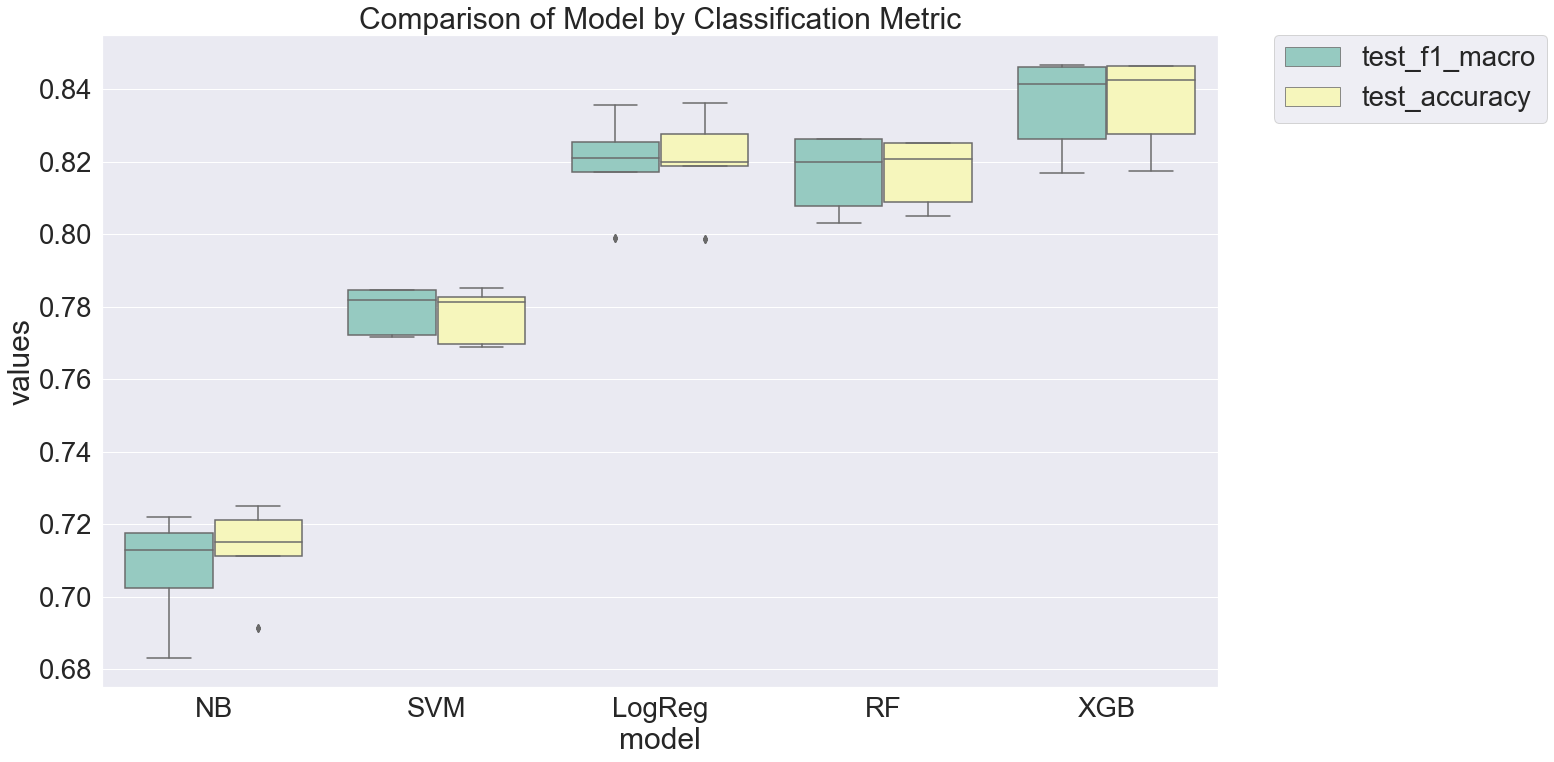

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

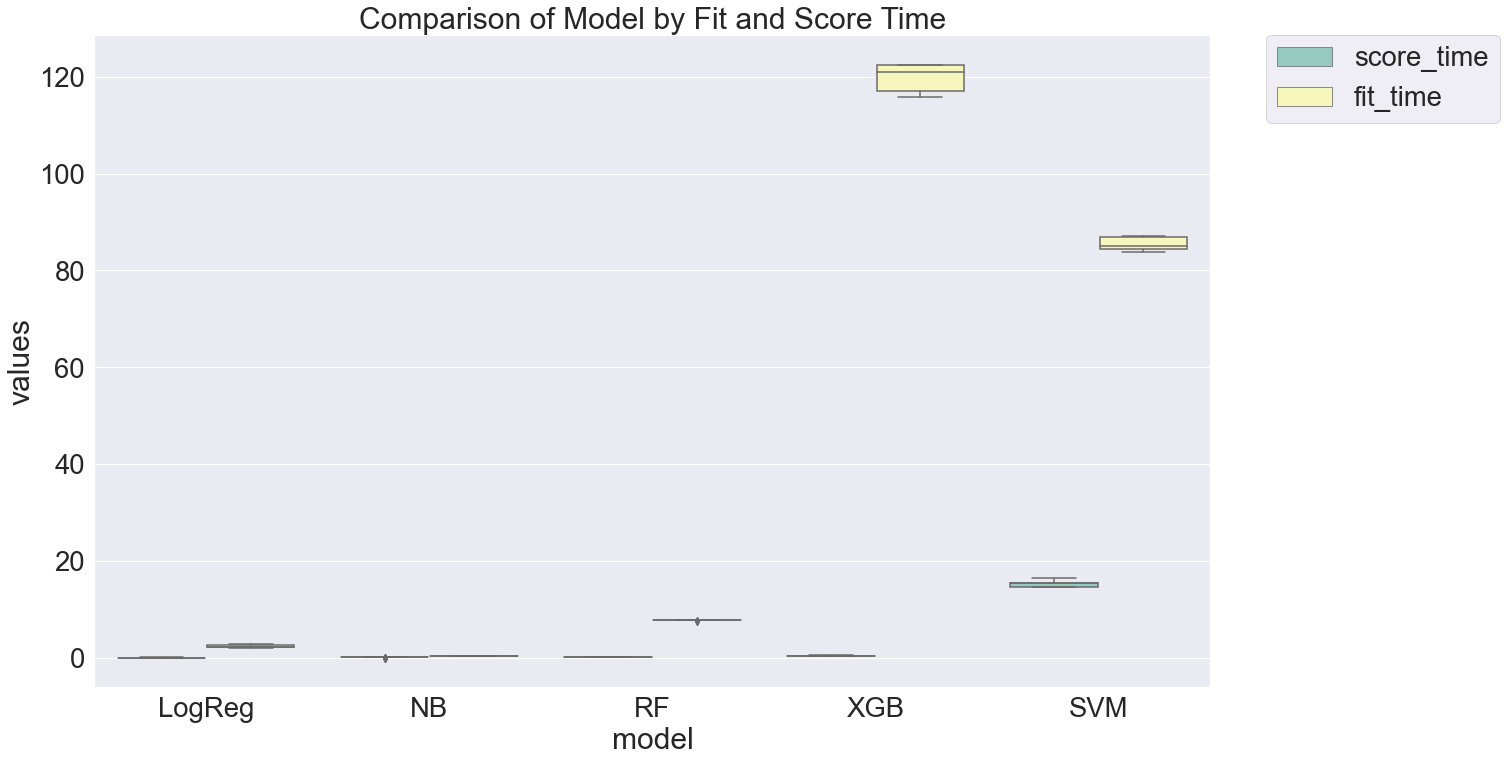

In [30]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [31]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.820292  0.011408      0.819480  0.011038
NB          0.714625  0.010607      0.709469  0.012632
RF          0.817750  0.008176      0.817624  0.009201
SVM         0.777208  0.006757      0.778623  0.005721
XGB         0.837375  0.011435      0.836703  0.011600

In [32]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

fit_time           score_time          
              mean       std       mean       std
model                                            
LogReg    2.423354  0.307478   0.082912  0.011553
NB        0.380453  0.019380   0.102487  0.005380
RF        7.801225  0.060769   0.136270  0.011125
SVM      85.467992  1.316260  15.291112  0.683768
XGB     119.745427  2.665111   0.477191  0.034739

# Text + "Original Average Word Length"

In [57]:
feature_df = pd.read_csv('./cleaned_csv/feature_df.csv',low_memory=False)
print('rows:',len(feature_df))

rows: 239850


In [58]:
feature_df.head(2)

,sentiment,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
0,Neutral,big group make reservation week advance,0.120370,0.055914,0.533333
1,Neutral,wait 20 minute drink another 30 breakfast not ...,0.111111,0.081413,0.285714


In [59]:
feature_df  = feature_df[['sentiment', 'cleaned_text', 'original_average_word_length']].copy()

In [60]:
feature_df.dropna(inplace = True)

In [61]:
feature_df = feature_df.sample(n=5000)

In [62]:
feature_df.sentiment.value_counts()

Good       1693
Neutral    1679
Poor       1628
Name: sentiment, dtype: int64

In [63]:
feature_df.head(1)

,sentiment,cleaned_text,original_average_word_length
18542,Neutral,vintage feel like prohibition era chicago,0.0908


In [64]:
y = feature_df["sentiment"]

In [65]:
y

18542     Neutral
14762     Neutral
90074        Good
95848        Good
37616     Neutral
           ...   
139660       Good
23979     Neutral
171912       Poor
99524        Good
229347       Poor
Name: sentiment, Length: 5000, dtype: object

In [66]:
x = feature_df.drop(columns = ["sentiment"])

In [67]:
x.head(1)

,cleaned_text,original_average_word_length
18542,vintage feel like prohibition era chicago,0.0908


In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, feature_df["sentiment"], test_size=0.2, random_state=123)

In [69]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (4000, 2)
y_train shape: (4000,)

x_test shape: (1000, 2)
y_test shape: (1000,)



In [70]:
#Count Vectors as features

In [71]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(feature_df['cleaned_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train["cleaned_text"])
xvalid_count =  count_vect.transform(x_test["cleaned_text"])

In [72]:
#create df for the vectors (both train and test)

In [73]:
x_train_count_vect_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names(),index= x_train.index)

In [74]:
x_test_count_vect_df = pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names(),index= x_test.index)

In [75]:
#concat x train data (merge with previously created features)
x_train_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_count = pd.concat([x_train_ready_for_concat, x_train_count_vect_df], axis=1)

In [76]:
#concat x test data (merge with previously created features)
x_test_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_count = pd.concat([x_test_ready_for_concat, x_test_count_vect_df], axis=1)

In [77]:
#def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

    
dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_count, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_count, y_train)
    y_pred = clf.predict(xvalid_count)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.9100    0.8168    0.8609       322
     Neutral     0.7602    0.9003    0.8243       331
        Good     0.8401    0.7723    0.8048       347

    accuracy                         0.8290      1000
   macro avg     0.8368    0.8298    0.8300      1000
weighted avg     0.8362    0.8290    0.8293      1000

RF
              precision    recall  f1-score   support

        Poor     0.8856    0.8416    0.8631       322
     Neutral     0.7895    0.9063    0.8439       331
        Good     0.8535    0.7723    0.8109       347

    accuracy                         0.8390      1000
   macro avg     0.8429    0.8401    0.8393      1000
weighted avg     0.8427    0.8390    0.8386      1000

SVM
              precision    recall  f1-score   support

        Poor     0.9480    0.7360    0.8287       322
     Neutral     0.7573    0.8580    0.8045       331
        Good     0.7387    0.7983    0.7673       347

    ac

In [78]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,2.898288,0.115897,0.84125,0.839539,LogReg
1,3.583940,0.145610,0.81750,0.814064,LogReg
2,3.178104,0.136636,0.83375,0.832898,LogReg
3,3.619748,0.150845,0.82250,0.821974,LogReg
4,3.299234,0.160954,0.82125,0.821601,LogReg
5,9.625609,0.138629,0.82625,0.825430,RF
6,10.902812,0.143133,0.83375,0.830262,RF
7,8.900947,0.151223,0.83250,0.830523,RF
8,8.987391,0.141959,0.83500,0.834119,RF
9,9.969467,0.175441,0.82500,0.823154,RF


In [79]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

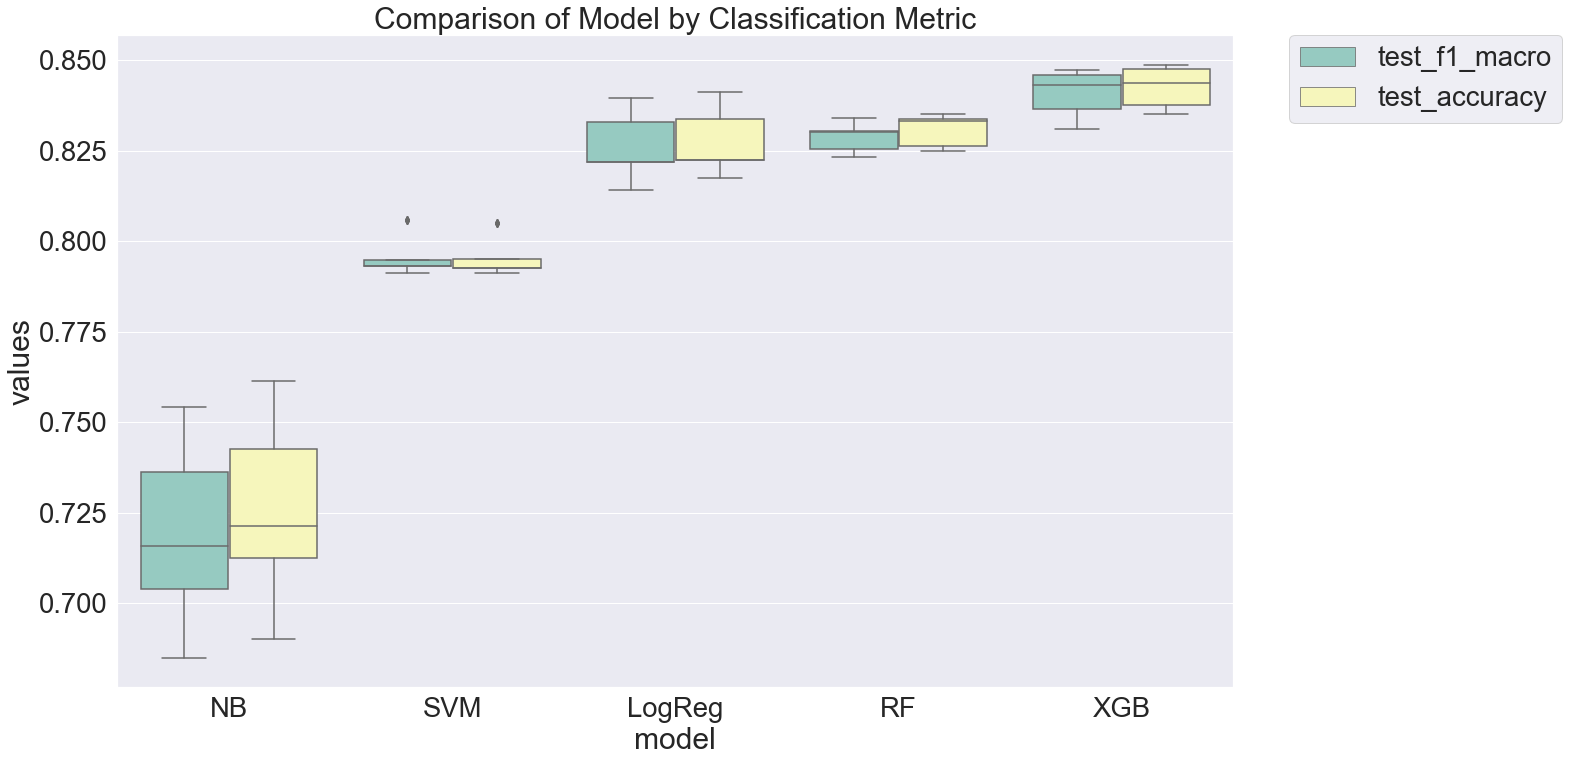

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

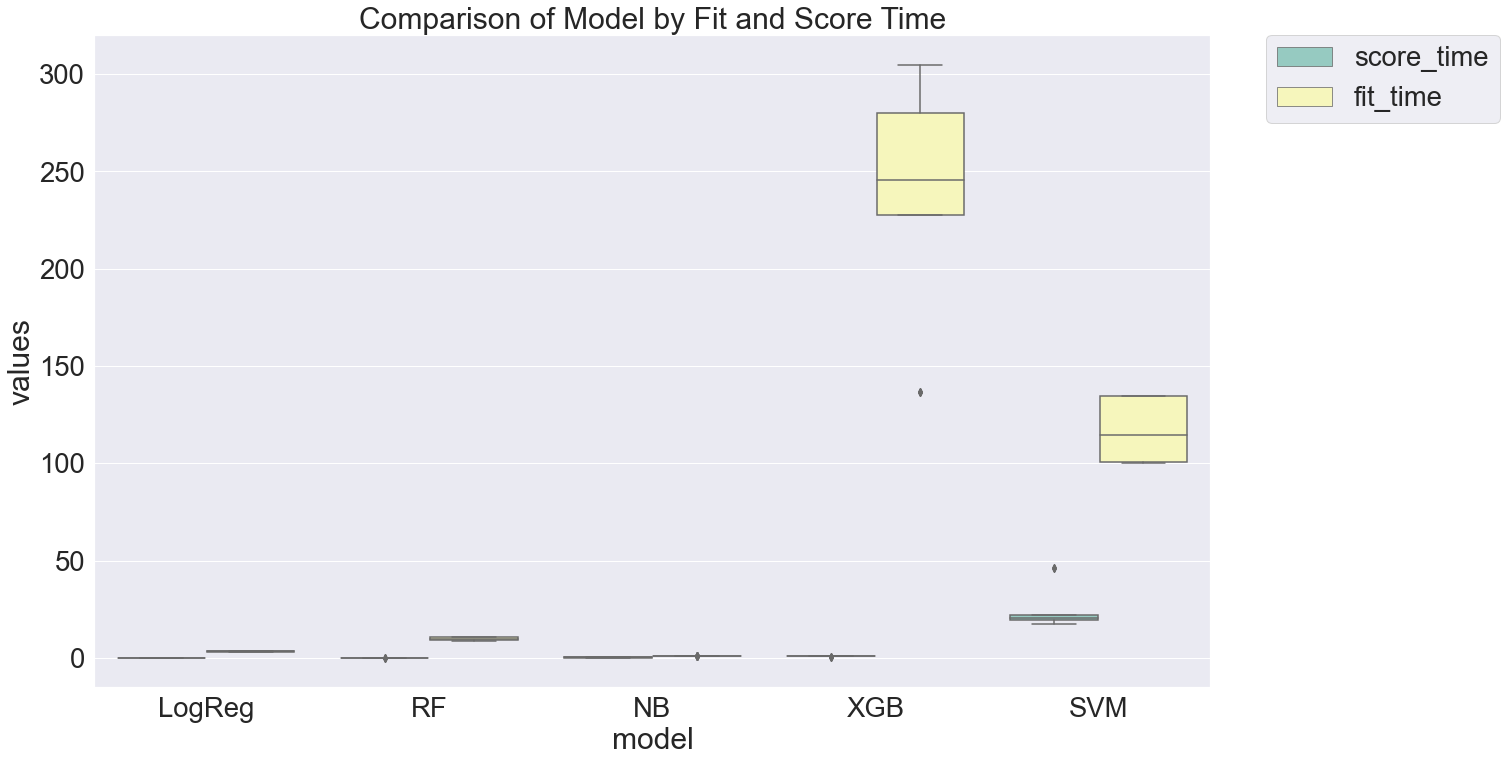

In [81]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [82]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.829125  0.008434      0.828296  0.008007
NB          0.723167  0.023412      0.716965  0.023020
RF          0.830958  0.004083      0.829121  0.003855
SVM         0.795542  0.005411      0.796102  0.005622
XGB         0.843042  0.005411      0.841298  0.006188

In [83]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

score_time              fit_time           
             mean       std        mean        std
model                                             
LogReg   0.140885  0.016109    3.293745   0.283783
NB       0.201018  0.010338    0.793724   0.020346
RF       0.147194  0.011881    9.766505   0.785190
SVM     23.075608  7.979800  118.568432  14.341321
XGB      0.867228  0.206254  247.574513  52.998227

# Text + "stopword_ratio"

In [60]:
feature_df = pd.read_csv('./cleaned_csv/feature_df.csv',low_memory=False)
print('rows:',len(feature_df))

rows: 239850


In [61]:
feature_df.head(2)

,sentiment,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
0,Neutral,big group make reservation week advance,0.120370,0.055914,0.533333
1,Neutral,wait 20 minute drink another 30 breakfast not ...,0.111111,0.081413,0.285714


In [62]:
feature_df  = feature_df[['sentiment', 'cleaned_text', 'stopword_ratio']].copy()

In [63]:
feature_df.dropna(inplace = True)

In [64]:
feature_df = feature_df.sample(n=5000)

In [65]:
feature_df.sentiment.value_counts()

Good       1706
Poor       1672
Neutral    1622
Name: sentiment, dtype: int64

In [66]:
feature_df.head(1)

,sentiment,cleaned_text,stopword_ratio
201717,Poor,chicken fresh bread cook house,0.375


In [67]:
y = feature_df["sentiment"]

In [68]:
y

201717       Poor
16796     Neutral
168042       Poor
168010       Poor
116355       Good
           ...   
143606       Good
106593       Good
12482     Neutral
228659       Poor
14570     Neutral
Name: sentiment, Length: 5000, dtype: object

In [69]:
x = feature_df.drop(columns = ["sentiment"])

In [70]:
x.head(1)

,cleaned_text,stopword_ratio
201717,chicken fresh bread cook house,0.375


In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, feature_df["sentiment"], test_size=0.2, random_state=123)

In [72]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (4000, 2)
y_train shape: (4000,)

x_test shape: (1000, 2)
y_test shape: (1000,)



In [73]:
#Count Vectors as features

In [74]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(feature_df['cleaned_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train["cleaned_text"])
xvalid_count =  count_vect.transform(x_test["cleaned_text"])

In [75]:
#create df for the vectors (both train and test)

In [76]:
x_train_count_vect_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names(),index= x_train.index)

In [77]:
x_test_count_vect_df = pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names(),index= x_test.index)

In [78]:
#concat x train data (merge with previously created features)
x_train_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_count = pd.concat([x_train_ready_for_concat, x_train_count_vect_df], axis=1)

In [79]:
#concat x test data (merge with previously created features)
x_test_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_count = pd.concat([x_test_ready_for_concat, x_test_count_vect_df], axis=1)

In [80]:
#def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

    
dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_count, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_count, y_train)
    y_pred = clf.predict(xvalid_count)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.8914    0.8134    0.8506       343
     Neutral     0.7713    0.8696    0.8175       322
        Good     0.8086    0.7821    0.7951       335

    accuracy                         0.8210      1000
   macro avg     0.8238    0.8217    0.8211      1000
weighted avg     0.8250    0.8210    0.8214      1000

RF
              precision    recall  f1-score   support

        Poor     0.8576    0.8426    0.8500       343
     Neutral     0.7678    0.9037    0.8302       322
        Good     0.8732    0.7403    0.8013       335

    accuracy                         0.8280      1000
   macro avg     0.8329    0.8289    0.8272      1000
weighted avg     0.8339    0.8280    0.8273      1000

SVM
              precision    recall  f1-score   support

        Poor     0.9349    0.7114    0.8079       343
     Neutral     0.7500    0.8478    0.7959       322
        Good     0.7307    0.8179    0.7718       335

    ac

In [81]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,4.269688,0.153531,0.81375,0.814028,LogReg
1,4.587798,0.144235,0.81500,0.814722,LogReg
2,4.916700,0.213742,0.80500,0.803396,LogReg
3,4.837884,0.228278,0.81750,0.817842,LogReg
4,5.328441,0.184126,0.80000,0.799503,LogReg
5,17.320821,0.298656,0.81250,0.813032,RF
6,17.231302,0.296736,0.82000,0.819550,RF
7,17.161359,0.291897,0.80625,0.804778,RF
8,17.153619,0.281775,0.82000,0.819043,RF
9,17.108330,0.292666,0.81875,0.818180,RF


In [82]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

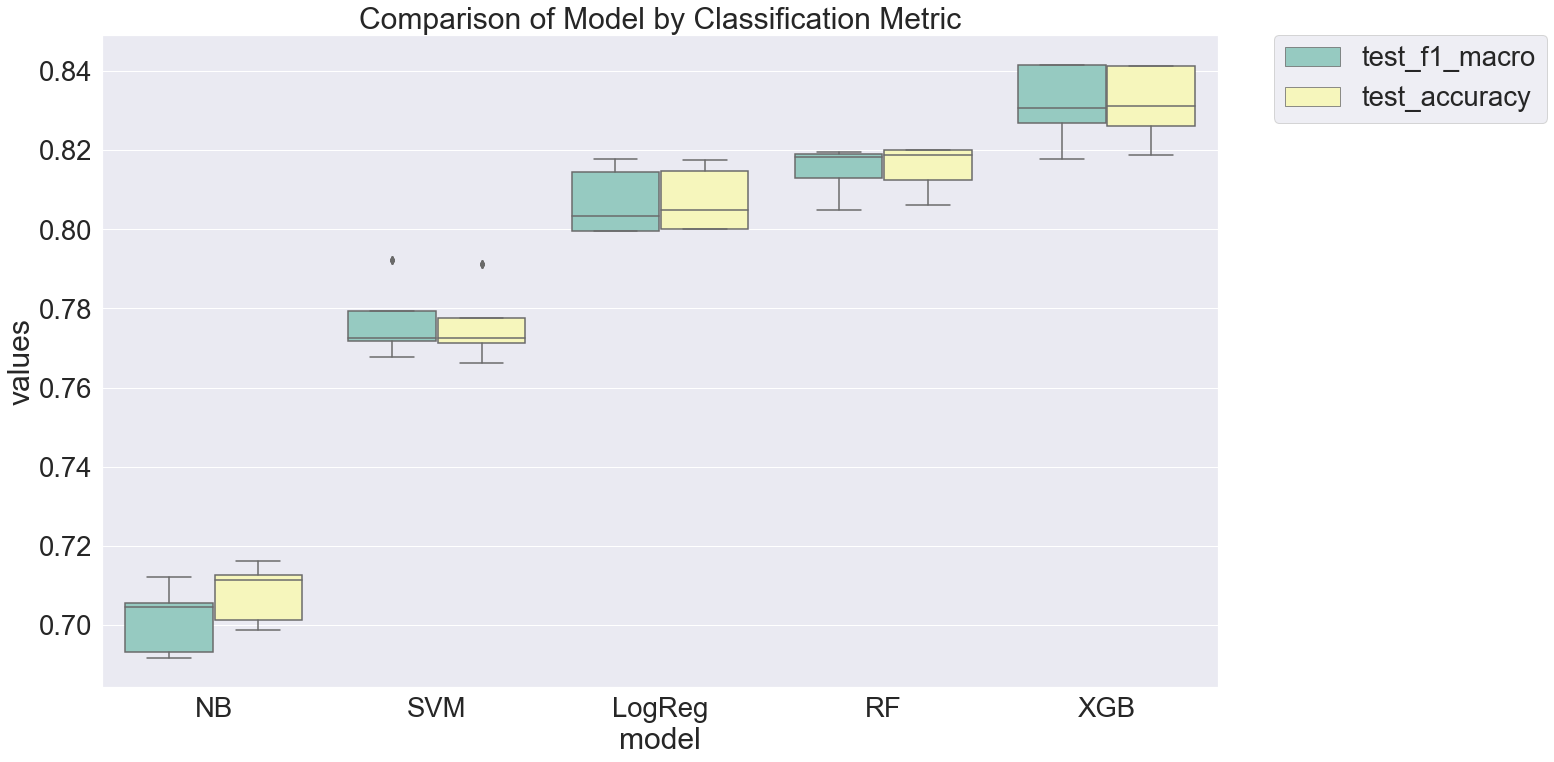

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

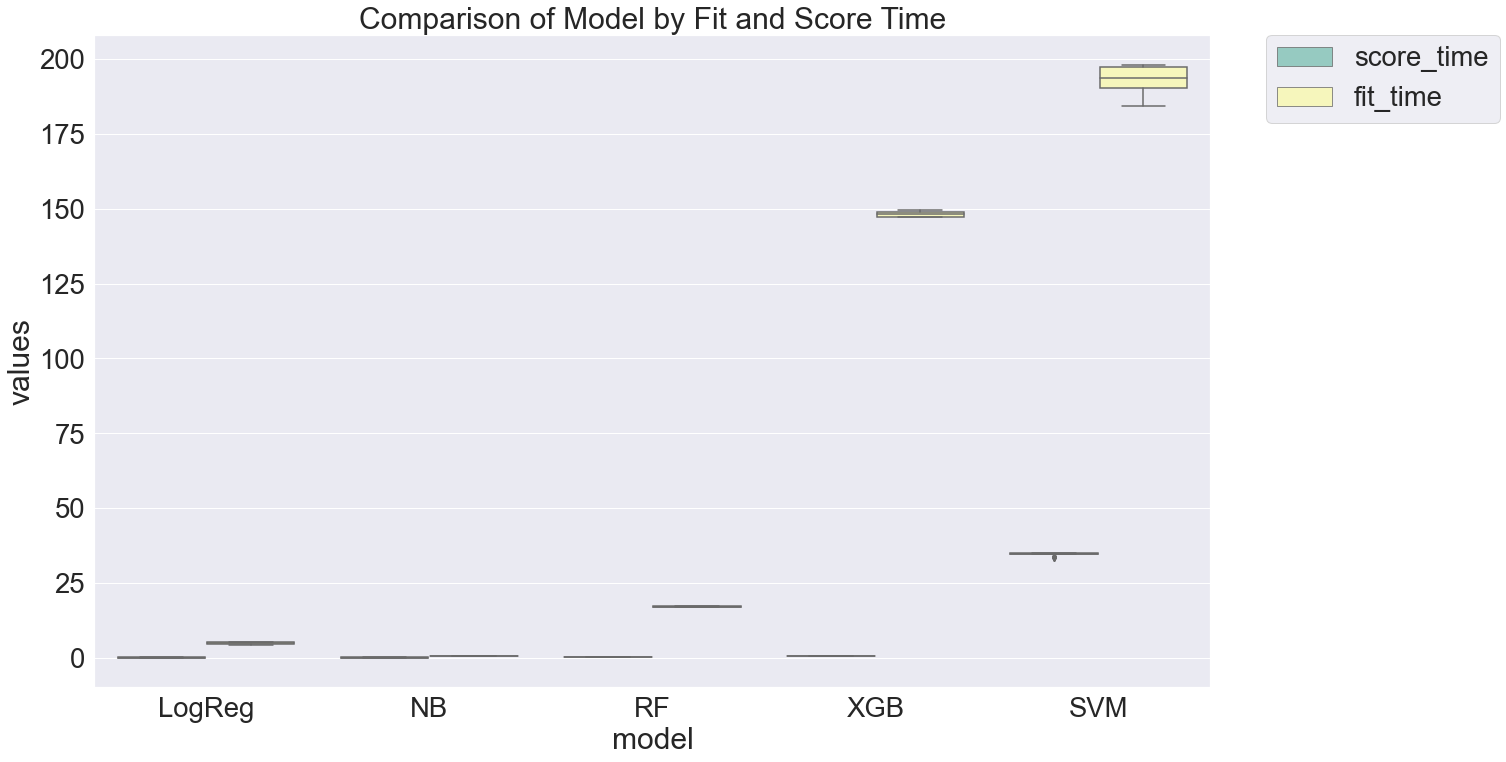

In [84]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [85]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.807875  0.006769      0.807332  0.007202
NB          0.708792  0.006643      0.701743  0.007741
RF          0.816167  0.004978      0.815599  0.004969
SVM         0.776167  0.009267      0.777213  0.009288
XGB         0.832583  0.007733      0.832792  0.007773

In [86]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

fit_time           score_time          
              mean       std       mean       std
model                                            
LogReg    4.869689  0.376560   0.184691  0.029649
NB        0.604789  0.047701   0.181854  0.014117
RF       17.189786  0.079017   0.290239  0.006984
SVM     192.291667  5.199279  34.723625  0.498632
XGB     148.129384  0.706601   0.771867  0.071547

# Text + "Original Word Count" + "original_average_word_length"

In [87]:
feature_df = pd.read_csv('./cleaned_csv/feature_df.csv',low_memory=False)
print('rows:',len(feature_df))

rows: 239850


In [88]:
feature_df.head(2)

,sentiment,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
0,Neutral,big group make reservation week advance,0.120370,0.055914,0.533333
1,Neutral,wait 20 minute drink another 30 breakfast not ...,0.111111,0.081413,0.285714


In [89]:
feature_df  = feature_df[['sentiment', 'cleaned_text', 'original_word_count','original_average_word_length']].copy()

In [90]:
feature_df.dropna(inplace = True)

In [91]:
feature_df = feature_df.sample(n=5000)

In [92]:
feature_df.sentiment.value_counts()

Poor       1703
Good       1678
Neutral    1619
Name: sentiment, dtype: int64

In [93]:
feature_df.head(1)

,sentiment,cleaned_text,original_word_count,original_average_word_length
34262,Neutral,bring cash not accept credit carddebit cardchecks,0.064815,0.105137


In [94]:
y = feature_df["sentiment"]

In [95]:
y

34262     Neutral
90453        Good
169055       Poor
126951       Good
24774     Neutral
           ...   
67543     Neutral
196360       Poor
10803     Neutral
190846       Poor
65142     Neutral
Name: sentiment, Length: 5000, dtype: object

In [96]:
x = feature_df.drop(columns = ["sentiment"])

In [97]:
x.head(1)

,cleaned_text,original_word_count,original_average_word_length
34262,bring cash not accept credit carddebit cardchecks,0.064815,0.105137


In [98]:
x_train, x_test, y_train, y_test = train_test_split(x, feature_df["sentiment"], test_size=0.2, random_state=123)

In [99]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (4000, 3)
y_train shape: (4000,)

x_test shape: (1000, 3)
y_test shape: (1000,)



In [100]:
#Count Vectors as features

In [101]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(feature_df['cleaned_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train["cleaned_text"])
xvalid_count =  count_vect.transform(x_test["cleaned_text"])

In [102]:
#create df for the vectors (both train and test)

In [103]:
x_train_count_vect_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names(),index= x_train.index)

In [104]:
x_test_count_vect_df = pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names(),index= x_test.index)

In [105]:
#concat x train data (merge with previously created features)
x_train_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_count = pd.concat([x_train_ready_for_concat, x_train_count_vect_df], axis=1)

In [106]:
#concat x test data (merge with previously created features)
x_test_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_count = pd.concat([x_test_ready_for_concat, x_test_count_vect_df], axis=1)

In [107]:
#def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

    
dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_count, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_count, y_train)
    y_pred = clf.predict(xvalid_count)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.9217    0.8094    0.8619       320
     Neutral     0.8010    0.9366    0.8635       331
        Good     0.8735    0.8309    0.8517       349

    accuracy                         0.8590      1000
   macro avg     0.8654    0.8590    0.8590      1000
weighted avg     0.8649    0.8590    0.8589      1000

RF
              precision    recall  f1-score   support

        Poor     0.8874    0.8125    0.8483       320
     Neutral     0.7720    0.9003    0.8312       331
        Good     0.8442    0.7765    0.8090       349

    accuracy                         0.8290      1000
   macro avg     0.8345    0.8298    0.8295      1000
weighted avg     0.8341    0.8290    0.8289      1000

SVM
              precision    recall  f1-score   support

        Poor     0.9522    0.6844    0.7964       320
     Neutral     0.7731    0.8852    0.8254       331
        Good     0.7519    0.8424    0.7946       349

    ac

In [108]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,4.324480,0.172427,0.81875,0.818550,LogReg
1,4.178131,0.233181,0.81000,0.811392,LogReg
2,4.282631,0.192017,0.83250,0.831300,LogReg
3,4.103856,0.215200,0.83125,0.831703,LogReg
4,4.512771,0.188915,0.83000,0.828278,LogReg
5,15.789791,0.278271,0.79000,0.790057,RF
6,15.999401,0.283787,0.79125,0.792176,RF
7,16.068724,0.285316,0.81250,0.810813,RF
8,15.966964,0.285090,0.82500,0.825569,RF
9,15.664507,0.288206,0.80750,0.805762,RF


In [109]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

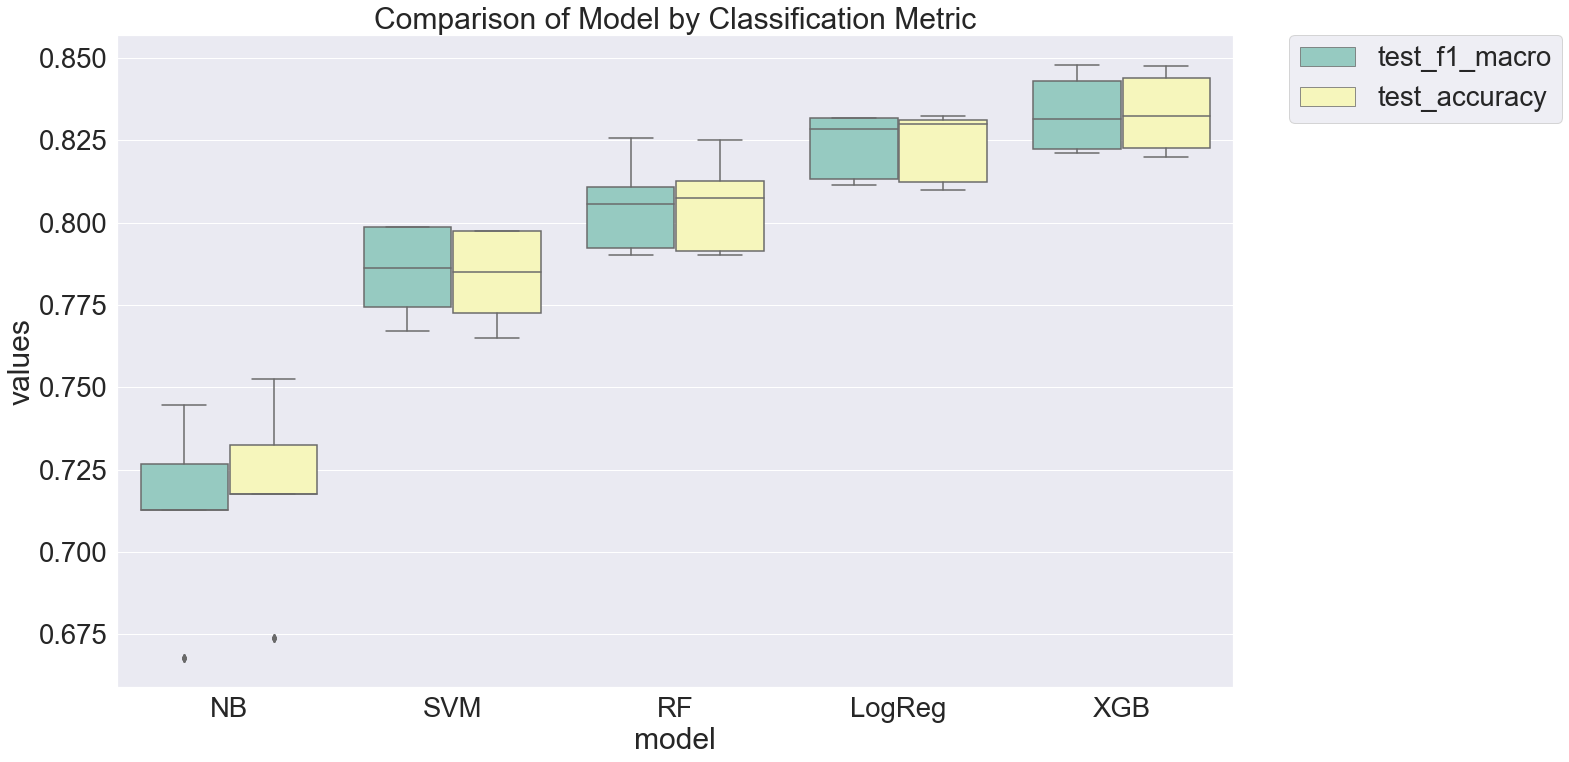

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

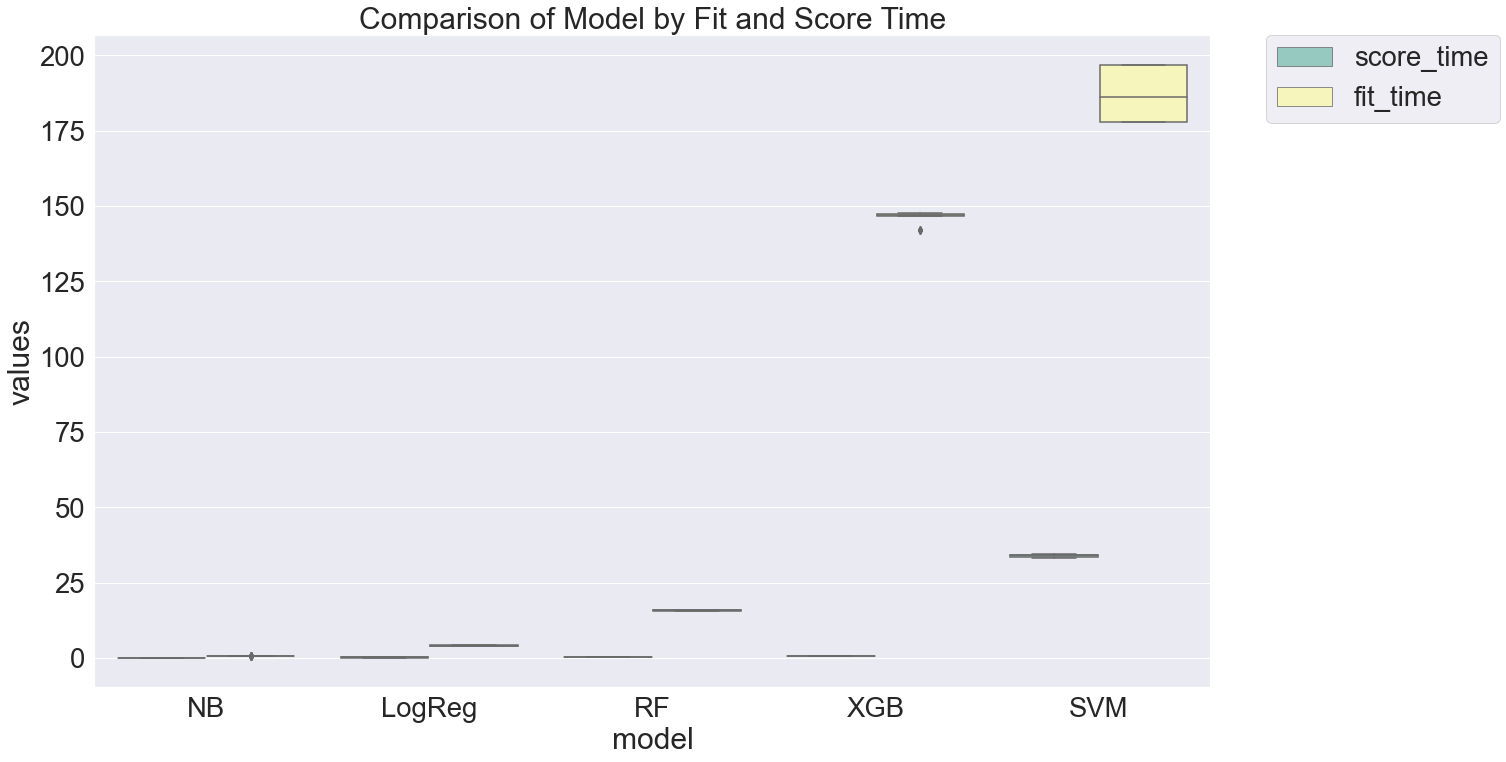

In [111]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [112]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.823375  0.009367      0.823497  0.008718
NB          0.715917  0.025716      0.709503  0.025211
RF          0.805708  0.013051      0.805301  0.012803
SVM         0.783333  0.014638      0.784789  0.014145
XGB         0.832708  0.010495      0.832539  0.010258

In [113]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

fit_time           score_time          
              mean       std       mean       std
model                                            
LogReg    4.240504  0.147076   0.206940  0.022141
NB        0.635251  0.008706   0.172022  0.006232
RF       15.887214  0.158195   0.284745  0.003064
SVM     188.042532  8.388199  33.979542  0.439034
XGB     146.342670  2.019668   0.767628  0.079841

# Text + "Original Word Count" + "stopword_ratio"

In [2]:
feature_df = pd.read_csv('./cleaned_csv/feature_df.csv',low_memory=False)
print('rows:',len(feature_df))

rows: 239850


In [3]:
feature_df.head(2)

,sentiment,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
0,Neutral,big group make reservation week advance,0.120370,0.055914,0.533333
1,Neutral,wait 20 minute drink another 30 breakfast not ...,0.111111,0.081413,0.285714


In [4]:
feature_df  = feature_df[['sentiment', 'cleaned_text', 'original_word_count','stopword_ratio']].copy()

In [5]:
feature_df.dropna(inplace = True)

In [6]:
feature_df = feature_df.sample(n=5000)

In [7]:
feature_df.sentiment.value_counts()

Poor       1713
Good       1647
Neutral    1640
Name: sentiment, dtype: int64

In [8]:
feature_df.head(1)

,sentiment,cleaned_text,original_word_count,stopword_ratio
20388,Neutral,organic non gmo yay,0.027778,0.2


In [9]:
y = feature_df["sentiment"]

In [10]:
y

20388     Neutral
12064     Neutral
116961       Good
45703     Neutral
232185       Poor
           ...   
140321       Good
102466       Good
50112     Neutral
180627       Poor
120658       Good
Name: sentiment, Length: 5000, dtype: object

In [11]:
x = feature_df.drop(columns = ["sentiment"])

In [12]:
x.head(1)

,cleaned_text,original_word_count,stopword_ratio
20388,organic non gmo yay,0.027778,0.2


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, feature_df["sentiment"], test_size=0.2, random_state=123)

In [14]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (4000, 3)
y_train shape: (4000,)

x_test shape: (1000, 3)
y_test shape: (1000,)



In [15]:
#Count Vectors as features

In [16]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(feature_df['cleaned_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train["cleaned_text"])
xvalid_count =  count_vect.transform(x_test["cleaned_text"])

In [17]:
#create df for the vectors (both train and test)

In [18]:
x_train_count_vect_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names(),index= x_train.index)

In [19]:
x_test_count_vect_df = pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names(),index= x_test.index)

In [20]:
#concat x train data (merge with previously created features)
x_train_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_count = pd.concat([x_train_ready_for_concat, x_train_count_vect_df], axis=1)

In [21]:
#concat x test data (merge with previously created features)
x_test_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_count = pd.concat([x_test_ready_for_concat, x_test_count_vect_df], axis=1)

In [22]:
#def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

    
dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_count, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_count, y_train)
    y_pred = clf.predict(xvalid_count)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.9231    0.8049    0.8599       328
     Neutral     0.7474    0.9191    0.8244       309
        Good     0.8503    0.7824    0.8149       363

    accuracy                         0.8320      1000
   macro avg     0.8402    0.8354    0.8331      1000
weighted avg     0.8424    0.8320    0.8326      1000

RF
              precision    recall  f1-score   support

        Poor     0.8942    0.7988    0.8438       328
     Neutral     0.7358    0.9191    0.8173       309
        Good     0.8474    0.7493    0.7953       363

    accuracy                         0.8180      1000
   macro avg     0.8258    0.8224    0.8188      1000
weighted avg     0.8282    0.8180    0.8180      1000

SVM
              precision    recall  f1-score   support

        Poor     0.9373    0.7287    0.8199       328
     Neutral     0.7294    0.8900    0.8017       309
        Good     0.7826    0.7934    0.7880       363

    ac

In [23]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,2.576708,0.082593,0.85000,0.848699,LogReg
1,2.142205,0.080464,0.83750,0.836950,LogReg
2,2.276010,0.090424,0.81625,0.816444,LogReg
3,2.240427,0.080567,0.85000,0.849587,LogReg
4,2.580100,0.092636,0.83250,0.834079,LogReg
5,7.259724,0.122736,0.83500,0.833547,RF
6,7.103166,0.120457,0.83000,0.827906,RF
7,6.952148,0.129836,0.79250,0.792747,RF
8,7.008655,0.141968,0.81625,0.814947,RF
9,7.037024,0.120584,0.80000,0.801039,RF


In [24]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

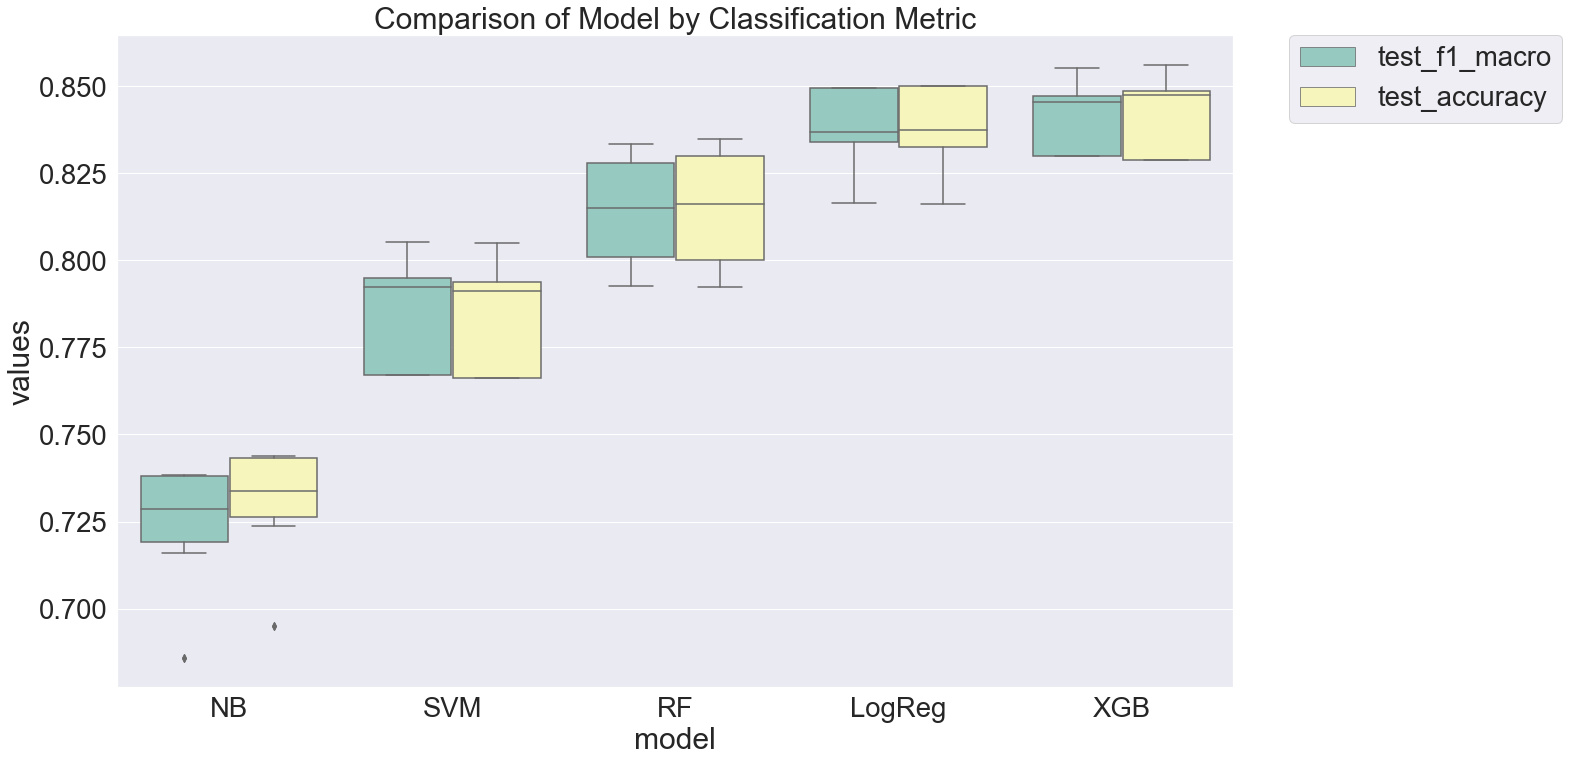

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

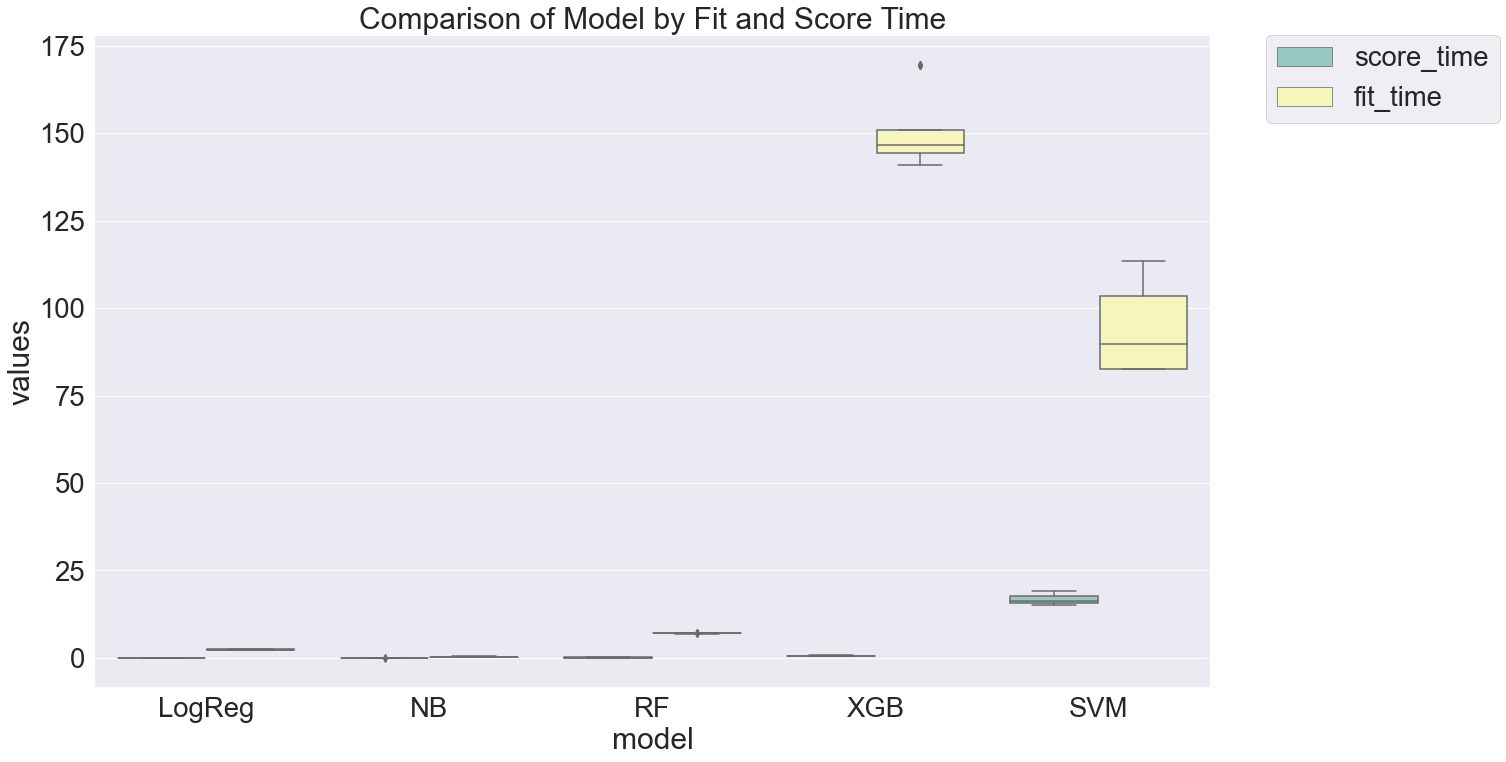

In [26]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [27]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.837125  0.013535      0.837074  0.013125
NB          0.732833  0.012598      0.727031  0.013925
RF          0.814500  0.015912      0.813693  0.014898
SVM         0.786125  0.014962      0.787128  0.014855
XGB         0.842375  0.010943      0.841941  0.009732

In [28]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

score_time              fit_time           
             mean       std        mean        std
model                                             
LogReg   0.085064  0.005299    2.322600   0.163018
NB       0.088187  0.008657    0.381304   0.035498
RF       0.128394  0.009022    7.057610   0.095764
SVM     16.629969  1.402091   94.125824  10.903657
XGB      0.613065  0.073766  151.095470  10.888668

# Text + "original_average_word_length" + "stopword_ratio"

In [29]:
feature_df = pd.read_csv('./cleaned_csv/feature_df.csv',low_memory=False)
print('rows:',len(feature_df))

rows: 239850


In [30]:
feature_df.head(2)

,sentiment,cleaned_text,original_word_count,original_average_word_length,stopword_ratio
0,Neutral,big group make reservation week advance,0.120370,0.055914,0.533333
1,Neutral,wait 20 minute drink another 30 breakfast not ...,0.111111,0.081413,0.285714


In [31]:
feature_df  = feature_df[['sentiment', 'cleaned_text', 'original_average_word_length','stopword_ratio']].copy()

In [32]:
feature_df.dropna(inplace = True)

In [33]:
feature_df = feature_df.sample(n=5000)

In [34]:
feature_df.sentiment.value_counts()

Neutral    1696
Poor       1668
Good       1636
Name: sentiment, dtype: int64

In [35]:
feature_df.head(1)

,sentiment,cleaned_text,original_average_word_length,stopword_ratio
12050,Neutral,gettin spam egg,0.053763,0.5


In [36]:
y = feature_df["sentiment"]

In [37]:
y

12050     Neutral
171647       Poor
78240     Neutral
123223       Good
19566     Neutral
           ...   
207221       Poor
101844       Good
7364      Neutral
160981       Poor
184828       Poor
Name: sentiment, Length: 5000, dtype: object

In [38]:
x = feature_df.drop(columns = ["sentiment"])

In [39]:
x.head(1)

,cleaned_text,original_average_word_length,stopword_ratio
12050,gettin spam egg,0.053763,0.5


In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, feature_df["sentiment"], test_size=0.2, random_state=123)

In [41]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (4000, 3)
y_train shape: (4000,)

x_test shape: (1000, 3)
y_test shape: (1000,)



In [42]:
#Count Vectors as features

In [43]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(feature_df['cleaned_text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train["cleaned_text"])
xvalid_count =  count_vect.transform(x_test["cleaned_text"])

In [44]:
#create df for the vectors (both train and test)

In [45]:
x_train_count_vect_df = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names(),index= x_train.index)

In [46]:
x_test_count_vect_df = pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names(),index= x_test.index)

In [47]:
#concat x train data (merge with previously created features)
x_train_ready_for_concat = x_train.drop(columns = ["cleaned_text"])
xtrain_count = pd.concat([x_train_ready_for_concat, x_train_count_vect_df], axis=1)

In [48]:
#concat x test data (merge with previously created features)
x_test_ready_for_concat = x_test.drop(columns = ["cleaned_text"])
xvalid_count = pd.concat([x_test_ready_for_concat, x_test_count_vect_df], axis=1)

In [49]:
#def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

    
dfs = []
models = [
        ('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier()),
        #('KNN', KNeighborsClassifier()),
        ('SVM', SVC()), 
        ('NB', MultinomialNB()),
        ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy','f1_macro']
target_names = ['Poor', 'Neutral','Good']

            
        
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = model_selection.cross_validate(model, xtrain_count, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(xtrain_count, y_train)
    y_pred = clf.predict(xvalid_count)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names,digits=4))

    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
#return final
            


LogReg
              precision    recall  f1-score   support

        Poor     0.9233    0.8426    0.8811       343
     Neutral     0.8036    0.9347    0.8642       337
        Good     0.8576    0.7906    0.8228       320

    accuracy                         0.8570      1000
   macro avg     0.8615    0.8560    0.8560      1000
weighted avg     0.8619    0.8570    0.8567      1000

RF
              precision    recall  f1-score   support

        Poor     0.9201    0.8397    0.8780       343
     Neutral     0.7926    0.9525    0.8652       337
        Good     0.8723    0.7688    0.8173       320

    accuracy                         0.8550      1000
   macro avg     0.8617    0.8536    0.8535      1000
weighted avg     0.8619    0.8550    0.8543      1000

SVM
              precision    recall  f1-score   support

        Poor     0.9586    0.7434    0.8374       343
     Neutral     0.7753    0.9110    0.8377       337
        Good     0.7692    0.8125    0.7903       320

    ac

In [50]:
final

,fit_time,score_time,test_accuracy,test_f1_macro,model
0,3.025220,0.114387,0.82375,0.823461,LogReg
1,3.421763,0.125638,0.83000,0.829966,LogReg
2,2.966856,0.104719,0.81250,0.813359,LogReg
3,3.240322,0.122675,0.83750,0.839203,LogReg
4,2.931554,0.130651,0.83625,0.838527,LogReg
5,9.623350,0.144767,0.81750,0.815704,RF
6,10.163368,0.194739,0.80750,0.805756,RF
7,11.389597,0.172552,0.81875,0.818718,RF
8,11.242197,0.171543,0.82750,0.828875,RF
9,11.093212,0.189637,0.83375,0.835625,RF


In [51]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

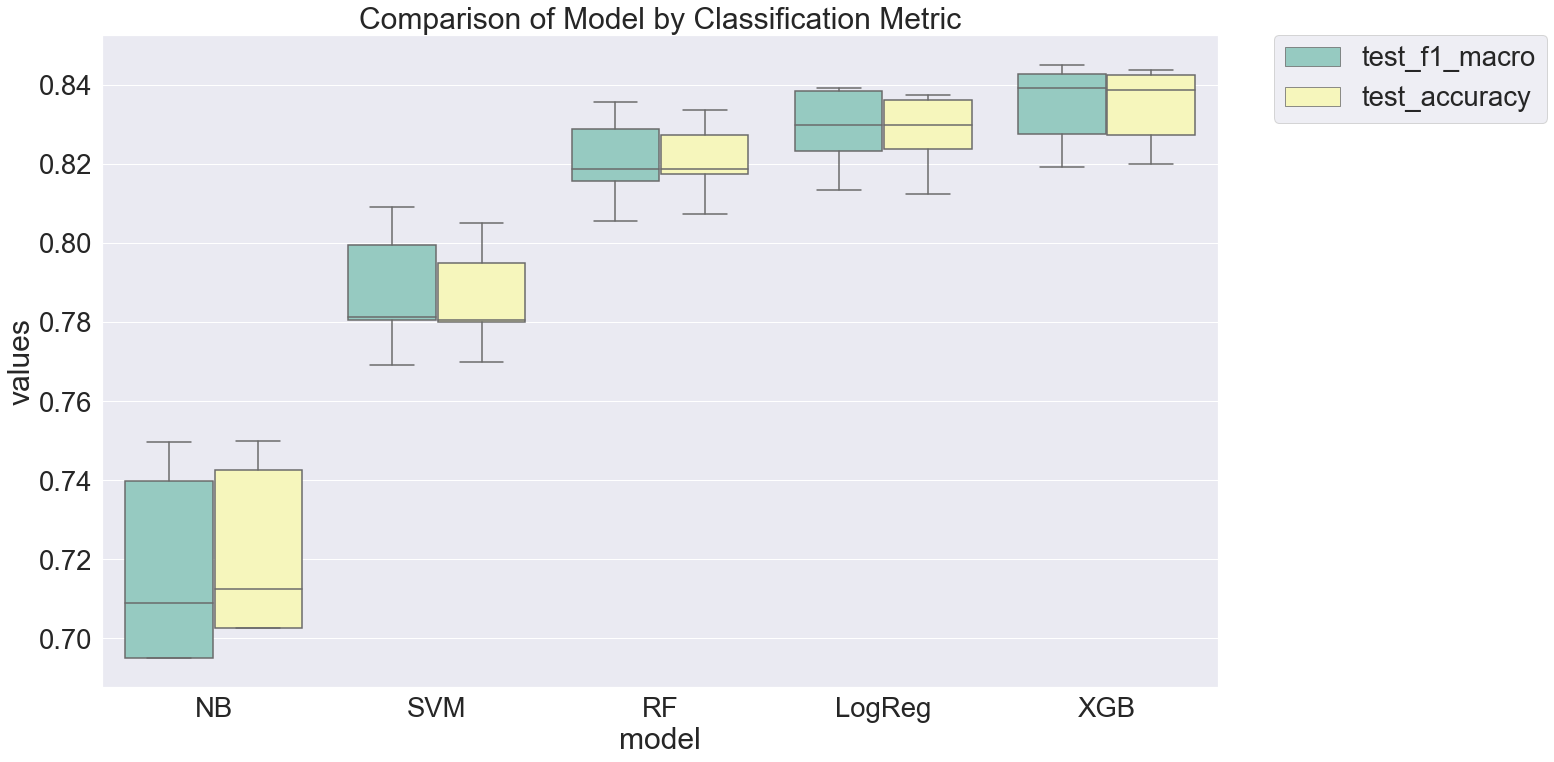

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

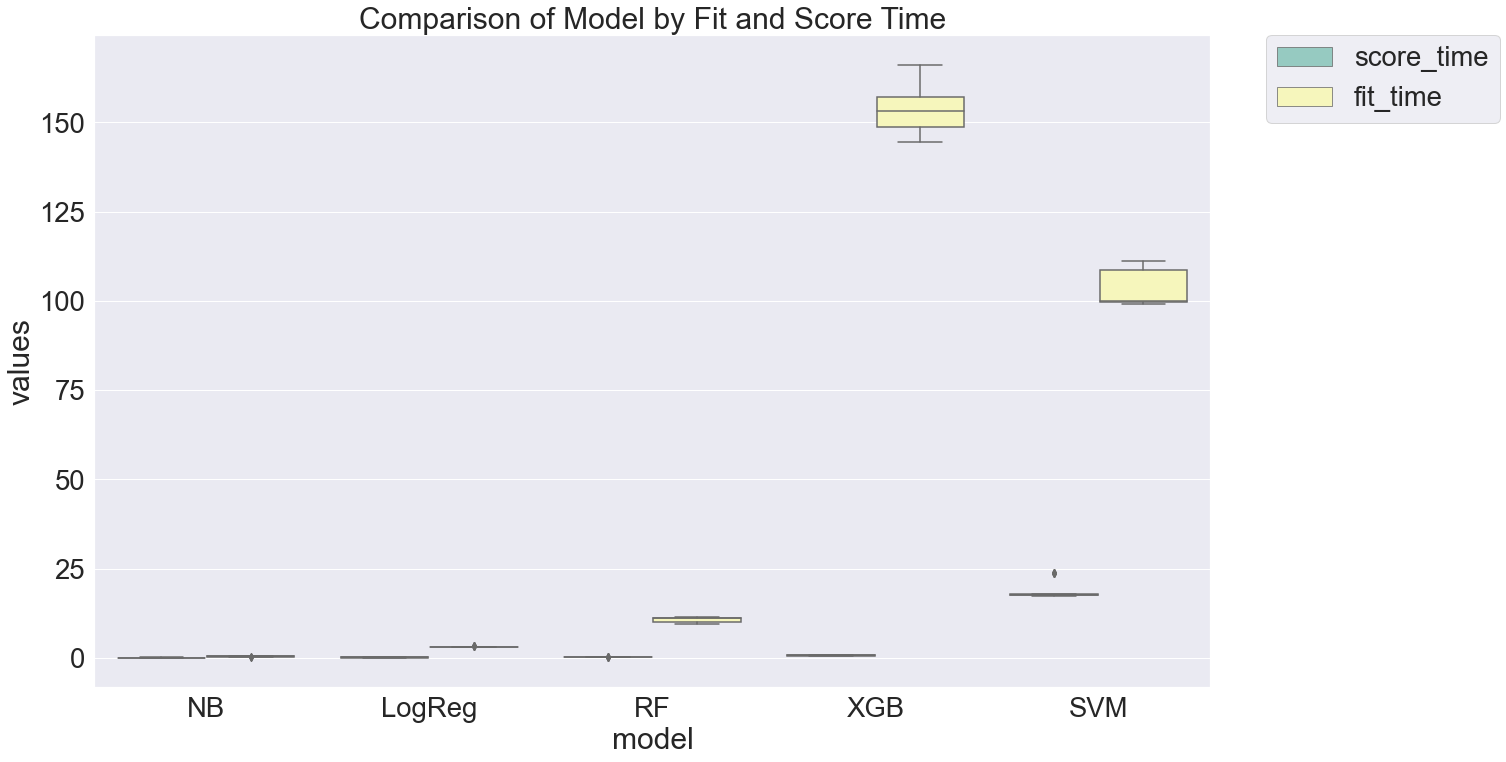

In [53]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [54]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean,np.std])

test_accuracy           test_f1_macro          
                mean       std          mean       std
model                                                 
LogReg      0.828458  0.009364      0.829601  0.010022
NB          0.720000  0.019130      0.715436  0.021614
RF          0.821875  0.008073      0.821926  0.009472
SVM         0.785667  0.013154      0.787364  0.015238
XGB         0.835167  0.009524      0.835547  0.010123

In [55]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.mean,np.std])

score_time              fit_time          
             mean       std        mean       std
model                                            
LogReg   0.121387  0.010231    3.056512  0.183370
NB       0.101811  0.016887    0.399150  0.030527
RF       0.170969  0.017096   10.725324  0.723565
SVM     19.062353  2.727114  102.839273  5.101198
XGB      0.657478  0.107069  154.676788  7.829804